# HYPER PARAMETER TUNING

Last step, we selected xgboost as our best performance model for loan default prediction, this step we will do 
hyperparameter tuning, which is the process of finding the best combination of hyperparameters for a xgboost to achieve optimal performance 

xgboost 

**Best model parameters**: {'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.3, 'xgb__max_depth': 9, 'xgb__n_estimators': 200} 

**Best model score**:  0.9012065393763203


**private score** 0.82431 
**public score** 0.81435


random forest 

**Best model parameters**: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}

**Best model score**:  0.904551

**private score** 0.82739
**public score** 0.82715

In [96]:
# Main tools we used:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import  make_scorer,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import xgboost as xgb
import lightgbm as lgb

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
import joblib


In [146]:
## last step, we found best performance dataset is processed dataset for xgboost
df_train_processed = pd.read_csv("processed_data_train.csv")
df_test_processed = pd.read_csv("processed_data_test.csv")

df_test= pd.read_csv("cs-test.csv")
df_train_oversampled = pd.read_csv("oversampled_data.csv")

## try to create new cols on top of oversampled data
# Create a new column 'TotalPastDue' by summing the values of the three columns
df_train_oversampled['TotalPastDue'] = df_train_oversampled['NumberOfTime30-59DaysPastDueNotWorse'] + df_train_oversampled['NumberOfTimes90DaysLate'] + df_train_oversampled['NumberOfTime60-89DaysPastDueNotWorse']

# Drop the individual columns if desired
df_train_oversampled = df_train_oversampled.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1)

# Create test dataset for new created cols
df_test_processed_created = df_test_processed.copy()
df_test_processed_created['TotalPastDue'] = df_test_processed_created['NumberOfTime30-59DaysPastDueNotWorse'] + df_test_processed_created['NumberOfTimes90DaysLate'] + df_test_processed_created['NumberOfTime60-89DaysPastDueNotWorse']
df_test_processed_created = df_test_processed_created.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1)


In [85]:
def split_data(X_train, Y_train, test_size=0.3, random_state=2020):
    """
    Split the data into training and validation sets.
    
    Parameters:
    - X_train: The features (input variables) for training.
    - Y_train: The target variable for training.
    - test_size: The proportion of the data to include in the validation set. Default is 0.3.
    - random_state: The random state for reproducibility. Default is 2020.
    
    Returns:
    - X_train: The training features.
    - val_x: The validation features.
    - Y_train: The training target variable.
    - val_y: The validation target variable.
    """
    X_train, val_x, Y_train, val_y = train_test_split(
        X_train, Y_train, test_size=test_size, random_state=random_state)
    
    return X_train, val_x, Y_train, val_y

In [86]:
def evaluate_model(model, X_train, Y_train, val_x, val_y):
    # Extract the model name from the model object
    model_name = type(model).__name__
    
    if '-' in model_name:
        model_name = model_name.split('-')[1]

    # Calculate the accuracy score on the training set
    accuracy_train = accuracy_score(Y_train, model.predict(X_train))
    print("Accuracy on training set:", accuracy_train)

    # Calculate the ROC AUC score on the training set
    roc_auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
    print("ROC AUC score on training set:", roc_auc_train)

    # Calculate the accuracy score on the validation set
    accuracy_val = accuracy_score(val_y, model.predict(val_x))
    print("Accuracy on validation set:", accuracy_val)

    # Calculate the ROC AUC score on the validation set
    roc_auc_val = roc_auc_score(val_y, model.predict_proba(val_x)[:, 1])
    print("ROC AUC score on validation set:", roc_auc_val)

    # Compute the false positive rate, true positive rate, and thresholds for training set
    fpr_train, tpr_train, thresholds_train = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])

    # Compute the false positive rate, true positive rate, and thresholds for validation set
    fpr_val, tpr_val, thresholds_val = roc_curve(val_y, model.predict_proba(val_x)[:, 1])

    # Plot the ROC curves
    plt.plot(fpr_train, tpr_train, label='Training')
    plt.plot(fpr_val, tpr_val, label='Validation')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Default')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ({})'.format(model_name))
    plt.legend()
    plt.show()


In [156]:
def display_evaluation_metrics(model, val_x, val_y):
    """
    Calculates and displays the evaluation metrics for a classification model.

    Parameters:
    - model: Trained classification model
    - val_x: Validation set features
    - val_y: Validation set target variable

    Prints a table showing the evaluation metrics: Accuracy, Precision, Recall, F1-score, AUC-ROC, and Gini coefficient.
    """
    
    # Make predictions on the validation set
    y_pred = model.predict(val_x)

    # Calculate accuracy
    accuracy = accuracy_score(val_y, y_pred)

    # Calculate precision
    precision = precision_score(val_y, y_pred)

    # Calculate recall
    recall = recall_score(val_y, y_pred)

    # Calculate F1-score
    f1 = f1_score(val_y, y_pred)

    # Calculate predicted probabilities for positive class
    y_pred_prob = model.predict_proba(val_x)[:, 1]

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(val_y, y_pred_prob)

    # Calculate Gini coefficient
    gini = 2 * auc_roc - 1

    # Create a list of metric names and values
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'Gini coefficient']
    metric_values = [accuracy, precision, recall, f1, auc_roc, gini]

    # Create a list of metric rows
    metric_rows = [[name, value] for name, value in zip(metric_names, metric_values)]

    # Print the table for evaluation metrics
    print(tabulate(metric_rows, headers=['Metric', 'Value'], tablefmt='orgtbl'))

### XGBOOST

In [5]:
## split df_train_processed data
## X_train, val_x, Y_train, val_y = split_data(df_train_processed.drop('SeriousDlqin2yrs', axis=1), df_train_processed['SeriousDlqin2yrs'])

In [142]:
## split oversampled data
X_train, val_x, Y_train, val_y = split_data(df_train_oversampled.drop('SeriousDlqin2yrs', axis=1), df_train_oversampled['SeriousDlqin2yrs'])

In [143]:
X_train

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,TotalPastDue
69651,0.057140,26,550.000000,5400.000000,3,0,0.000000,0
176886,1.000000,32,0.131231,1249.118071,1,0,1.763858,1
104414,1.000000,28,0.092987,5118.000000,4,0,1.000000,0
7720,0.506165,23,0.019026,3100.000000,4,0,0.000000,0
115695,0.116326,49,0.462667,6200.000000,15,2,2.000000,1
...,...,...,...,...,...,...,...,...
151709,1.044848,50,0.432649,15000.000000,10,2,2.000000,0
96184,0.896048,33,0.644385,2617.000000,10,1,0.000000,0
20039,0.012690,54,0.219867,6180.000000,17,3,0.000000,0
18523,0.344479,63,0.165955,28350.000000,4,2,0.000000,0


In [6]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)
xgb_cfl.fit(X_train, Y_train)
y_pred = xgb_cfl.predict(val_x)
y_score = xgb_cfl.predict_proba(val_x)[:,1]

In [127]:
from collections import Counter
counter = Counter(Y_train)
# estimate scale_pos_weight value to handle class imbalance during training
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    'xgb__eta': [0.05, 0.1, 0.3],
    'xgb__max_depth': [3, 6, 12],
    'xgb__colsample_bytree': [0.9, 1.0],
    'xgb__n_estimators': [50, 100, 200]
    }
#define the pipeline
model_pipe = Pipeline([
    ('xgb', xgb.XGBClassifier(
                              n_jobs=-1, scale_pos_weight=estimate))
])
#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=3, 
                   verbose=50, 
                   scoring='roc_auc')
#fit to training data
clf.fit(X_train, Y_train)

# Get the best-performing model based on validation set AUC score
best_model = clf.best_estimator_

Estimate: 1.001
Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [128]:
# Define the scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Define the parameter grid
clf_grid = {
    'xgb__eta': [0.05, 0.1, 0.3],
    'xgb__max_depth': [3, 6, 9],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__n_estimators': [100, 150, 200]
}

# Define the pipeline
model_pipe = Pipeline([
    ('xgb', xgb.XGBClassifier(n_jobs=-1, scale_pos_weight=estimate))
])

# Define the classifier
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=3,
                   verbose=50,
                   scoring=scoring_metrics,
                   refit='roc_auc')  # You can specify the desired metric for refitting the best model

# Fit to the training data
clf.fit(X_train, Y_train)

# Get the best-performing model based on the specified scoring metric
best_model = clf.best_estimator_

# Make predictions on the validation set
y_pred = best_model.predict(val_x)

# Calculate the desired evaluation metrics
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
f1 = f1_score(val_y, y_pred)

# Print the evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("F1-score: {:.4f}".format(f1))

print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Accuracy: 0.9058
Precision: 0.9151
F1-score: 0.9049
Best model parameters: 

{'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.3, 'xgb__max_depth': 9, 'xgb__n_estimators': 200}
Best model score: 

0.9012065393763203


In [ ]:
evaluate_model(best_model, X_train, Y_train, val_x, val_y)
display_evaluation_metrics(best_model, val_x, val_y)


In [130]:
from tabulate import tabulate

# Create a list of metric names and values
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'Gini coefficient']
metric_values = [accuracy, precision, recall, f1, auc_roc, gini]

# Create a list of metric rows
metric_rows = [[name, value] for name, value in zip(metric_names, metric_values)]

# Print the table for evaluation metrics
print(tabulate(metric_rows, headers=['Metric', 'Value'], tablefmt='orgtbl'))

| Metric           |    Value |
|------------------+----------|
| Accuracy         | 0.905825 |
| Precision        | 0.915072 |
| Recall           | 0.976083 |
| F1-score         | 0.904912 |
| AUC-ROC          | 0.969846 |
| Gini coefficient | 0.939692 |


In [133]:
df_test_oversampled = df_test_processed
# Create a new column 'TotalPastDue' by summing the values of the three columns
df_test_oversampled['TotalPastDue'] = df_test_processed['NumberOfTime30-59DaysPastDueNotWorse'] + df_test_processed['NumberOfTimes90DaysLate'] + df_test_processed['NumberOfTime60-89DaysPastDueNotWorse']
# Drop the individual columns if desired

df_test_oversampled = df_test_processed.drop(['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse'], axis=1)

test_X = df_test_oversampled.drop(["SeriousDlqin2yrs"],axis=1)

In [134]:
# Get the best model from GridSearchCV

## Prediction_XGB = best_model.predict(X_train)

predict_prob = best_model.predict_proba(test_X)[:, -1]

In [135]:
# Use the best model from GridSearchCV to predit for test data
df_test_id =df_test["Unnamed: 0"]
result = pd.DataFrame({"Id": df_test_id, "Probability": predict_prob})
result["Id"] = result["Id"].astype(int)
result["Probability"] = result["Probability"].astype(float)


In [137]:
# Save the best model from GridSearchCV to predit for test data to csv
result.to_csv('model_output/predictions-best_model_xgboost.csv', index=False)

In [138]:
# Save the best model for XGBoost
joblib.dump(best_model, 'models/best_model_XGBOOST.pkl')

['models/best_model_XGBOOST.pkl']

In [ ]:
model = RandomizedSearchCV(xgb, param_distributions=TRAIN_CONFIGS["model_params"], n_iter=400, scoring='roc_auc', n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 0), verbose=3, random_state=0)

In [23]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

In [24]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [25]:
### HYPER PARAMETER TUNING
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

#### SVC Model ####

In [ ]:
# c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
# kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
# param_grid = {'C': c_values, 'kernel': kernel_values}

# model_SVC = SVC()
# SVC_GridSearch = GridSearchCV(model_SVC, param_grid, scoring='f1_weighted')

# SVC_GridSearch.fit(X_train, Y_train)
# best_model = SVC_GridSearch.best_estimator_

In [ ]:
# Prediction_SVC = best_model.predict(X_train)

#### RANDOM FOREST ####

In [163]:
# wanted to tunning against max_features_list=['auto', 'sqrt', 'log2', None] but it’s taking such long time to train (overnight) 
n_estimators_value = [100,150,200,250,300]
criterion_val = ["gini", "entropy"]
max_depth_val = [5, 10, 15, None]
# max_features_list=['auto', 'sqrt', 'log2', None]
param_grid = dict(criterion=criterion_val, n_estimators=n_estimators_value,max_depth=max_depth_val )

model_RF = RandomForestClassifier()
RF_GridSearch = GridSearch(X_train,Y_train,model_RF,param_grid)

## private score 0.8471 public score 0.8425
best_model, best_params = RF_GridSearch.GridSearch()

## Prediction_GB = GB_GridSearch.BestModelPridict(X_test)

Best: 0.904551 using {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}


In [164]:
best_params


{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}

Accuracy on training set: 0.9993446988760275
ROC AUC score on training set: 0.9998936957956608
Accuracy on validation set: 0.9056659164301791
ROC AUC score on validation set: 0.9699927128510653


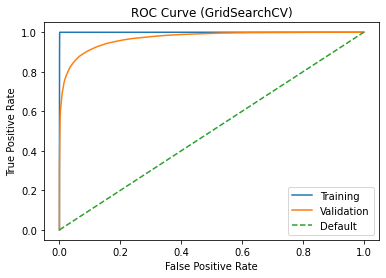

In [165]:
evaluate_model(best_model, X_train, Y_train, val_x, val_y)


In [166]:
display_evaluation_metrics(best_model, val_x, val_y)


| Metric           |    Value |
|------------------+----------|
| Accuracy         | 0.905666 |
| Precision        | 0.903099 |
| Recall           | 0.909144 |
| F1-score         | 0.906112 |
| AUC-ROC          | 0.969993 |
| Gini coefficient | 0.939985 |


In [167]:
X_test = df_test_processed_created.drop(["SeriousDlqin2yrs"],axis=1)
# Use the best model for prediction
probabilities = best_model.predict_proba(X_test)

# Extract the probability of belonging to the positive class (default)
default_probabilities = probabilities[:, 1]


In [168]:
result = pd.DataFrame({"Id": df_test_id, "Probability": default_probabilities})
result["Id"] = result["Id"].astype(int)
result["Probability"] = result["Probability"].astype(float)

result.to_csv('model_output/predictions-best_model_RF.csv', index=False)


In [169]:
joblib.dump(best_model, 'models/best_model_RF.pkl')

['models/best_model_RF.pkl']

#### KNN ####

In [54]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

In [55]:
KNN_GridSearch = GridSearch(X_train,Y_train,model_KNN,param_grid)
best_model, best_params = KNN_GridSearch.GridSearch()
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_train)


Best: 0.932573 using {'n_neighbors': 8}
Best: 0.932573 using {'n_neighbors': 8}


In [40]:
cp = classification_report(Y_train,Prediction_KNN)
print(cp)


              precision    recall  f1-score   support

           0       0.93      1.00      0.97     95298
           1       0.88      0.01      0.03      6916

    accuracy                           0.93    102214
   macro avg       0.90      0.51      0.50    102214
weighted avg       0.93      0.93      0.90    102214



In [58]:
# Use the best KNN model for prediction
probabilities = best_model.predict_proba(X_test)

# Extract the probability of belonging to the positive class (default)
default_probabilities = probabilities[:, 1]


array([0.  , 0.  , 0.  , ..., 0.  , 0.25, 0.  ])

In [57]:
result = pd.DataFrame({"Id": df_test_id, "Probability": default_probabilities})
result["Id"] = result["Id"].astype(int)
result["Probability"] = result["Probability"].astype(float)

result.to_csv('predictions-best_model_model_KNN.csv', index=False)


### LogisticRegression

In [61]:
# model
model = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [62]:
LR_RandSearch = RandomSearch(X_train,Y_train,model,hyperparameters)
LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_train)



/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
460 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
460 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

Best: 0.934666 using {'C': 2.681870040713609, 'penalty': 'l2'}


/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
460 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
460 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

Best: 0.934666 using {'C': 2.681870040713609, 'penalty': 'l2'}


/Users/tianhuihu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
cp = classification_report(Y_train,Prediction_LR)
print(cp)




              precision    recall  f1-score   support

           0       0.94      1.00      0.97     95298
           1       0.61      0.08      0.14      6916

    accuracy                           0.93    102214
   macro avg       0.77      0.54      0.56    102214
weighted avg       0.92      0.93      0.91    102214



In [64]:
# Use the best LR model for prediction
# 0.7923 private score 0.7899 public score
probabilities = LR_best_model.predict_proba(X_test)

# Extract the probability of belonging to the positive class (default)
default_probabilities = probabilities[:, 1]




In [65]:
result = pd.DataFrame({"Id": df_test_id, "Probability": default_probabilities})
result["Id"] = result["Id"].astype(int)
result["Probability"] = result["Probability"].astype(float)

result.to_csv('predictions-best_model_LR.csv', index=False)

In [ ]:
### ADABOOST CLASSIFIER ###

In [73]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)


In [76]:
model_Ad = AdaBoostClassifier()
Ad_GridSearch = GridSearch(X_train,Y_train,model_Ad,param_grid)
Prediction_Ad = Ad_GridSearch.BestModelPridict(X_train)


Best: 0.935723 using {'learning_rate': 0.05, 'n_estimators': 300}
